# TSM_CompVis HS 23 Homework Assignment 1

Author: Luzian Scherrer ([luzian@scherrer.ch](mailto:luzian@scherrer.ch))

GitHub: https://github.com/luzianscherrer/mlcompvis/tree/main/assignment1

## Summary and Conclusion

**What is working well**

- The detection of the sheet of paper, its orientation and the according transformation to a rectangular image are all working well.
- The detection of the numbers on the sheet is working fairly well, with only very few numbers missed but with a non-neglectable amount of false positives.
- The classification of the correctly oriented numbers is working very well.

**Open issues and problems**

- The detection of the orientation of the numbers (rotation by 0, 90, 180, 270 degrees) is not working. Many different approaches like various augmentation techniques of the training data, hyperparameter tuning of the neural network and other classifiers and even integration of the [USPS Dataset](https://ieeexplore.ieee.org/document/291440) have been tried, all without success. There is of course also the possibility of a subtle bug in the code.
- How can the classification discard non numbers? Training a potentially infinite set of non numbers does not seem feasible.

**Conclusion**

It is interesting to see that with the exact same training data one task (number classification) is straight forward to achieve while another seemingly similar task (rotation classification) is very difficult. The fact that for example the orientation of the numbers "5" of the input set is very easy to see for a human while all models are failing miserably to detect it is also rather sobering (see [Debugging](#Debugging) for an example).

## Implementation

### Configuration

In [1]:
imgdir = "homework images vol 1"
# imgdir = "testing"
verbose = False

### Imports

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import skimage
import skimage.transform.hough_transform as ht
import copy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import save_model, load_model
from scipy import ndimage

2023-10-28 08:58:29.428365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Tuning Parameters

In [3]:
sdd = 0.4               # sheet detection, darkening
sdcs = 2                # sheet detection, canny sigma
sdhtt = np.deg2rad(10)  # sheet detection, hough theta tolerance
sdhdt = 100             # sheet detection, hough distance tolerance
a4w,a4h = 420, 594      # a4 portrait dimensions
rms = 10                # digit detection, minimum region size
bbs = 50                # digit detection, background blur sigma
dis = 28                # extracted digit image size

### Implementation

In [4]:
def get_scaled_images(imgdir):
    for imgfile in os.listdir(imgdir):
        print(f"\n\nProcessing {imgfile}")
        imdata_orig = skimage.io.imread(os.path.join(imgdir, imgfile))
        scale_factor = 1000/max(imdata_orig.shape)
        # rescale to max 1000 pixels and convert to floats of range [0-1]
        imdata = skimage.transform.rescale(imdata_orig, scale_factor)
        # remove size 1 dimension
        imdata = np.squeeze(imdata)
        yield imdata

In [5]:

def find_sheet_lines(imdata):
    imdatacopy = copy.deepcopy(imdata)
    # make the image darker in order to get rid of the black lines in the floor
    imdatacopy -= sdd
    imdatacopy[imdatacopy < 0] = 0

    imedges = skimage.feature.canny(imdatacopy, sigma=sdcs)
    hough_space, angles, distances = ht.hough_line(imedges)

    if verbose:
        print(f"hough_space.shape {hough_space.shape}")

    # list of the elements of the form (dist, theta)
    known_lines = []
    for _ in range(100):
        maxflat = np.argmax(hough_space)
        maxrow, maxcol = np.unravel_index(maxflat, hough_space.shape)

        hough_space[maxrow, maxcol] = 0

        dist = distances[maxrow]
        theta = angles[maxcol]
        
        if verbose:
            print(f"candidate dist {dist} / theta {theta}")

        # only keep lines that are not too similar according to sheet_distance_tolerance and sheet_theta_tolerance
        valid_candidate = True
        for known_line in known_lines:
            if abs(known_line[0] - dist) < sdhdt and abs(known_line[1] - theta) < sdhtt:
                valid_candidate = False
                if verbose:
                    print("not passed because too similar")
                continue
            # special case: if theta is almost pi/2 or -pi/2 a special comparsion is needed to check for similarity
            if abs(known_line[1] - theta) > np.pi - sdhtt and abs(abs(known_line[0]) - abs(dist)) < sdhdt:
                valid_candidate = False
                if verbose:
                    print("not passed because too similar (special case)")
                continue
        if valid_candidate == False:
            continue

        if verbose:
            print("passed")
        known_lines.append((dist, theta))

        if len(known_lines) == 4:
            break

    return known_lines, imedges


In [6]:
def find_intersections(lines, imdata):
    # convert to homogeneous lines
    homogeneous_lines = []
    for line in lines:
        denom = np.sin(line[1])
        if denom == 0:
            denom = 0.0001
        x0 = 0
        y0 = (line[0]-x0*np.cos(line[1])) / denom
        x1 = 1000
        y1 = (line[0]-x1*np.cos(line[1])) / denom
        homogeneous_lines.append(np.cross([x0, y0, 1], [x1, y1, 1]))

    # calculate intersections
    homogeneous_intersections = []
    for i, line in enumerate(homogeneous_lines):
        for other_line in homogeneous_lines[i+1:]:
            homogeneous_intersections.append(np.cross(line, other_line))

    # convert to cartesian points
    intersections = list(map(lambda a: (a[0]/a[2], a[1]/a[2]), homogeneous_intersections))

    # calculate distances to center of image
    cx = imdata.shape[1]//2
    cy = imdata.shape[0]//2
    intersections.sort(key=lambda a: ((a[0]-cx)**2+(a[1]-cy)**2)**0.5)
    if verbose:
        print(f"all intersections: {intersections}")

    # return the four nearest intersections
    return intersections[:4]

In [7]:
def sort_intersections(intersections):
    intersections = copy.deepcopy(intersections)
    a = sorted(intersections, key=lambda x: x[0])[0]
    intersections.remove(a)
    b = sorted(intersections, key=lambda x: x[1], reverse=True)[0]
    intersections.remove(b)
    c = sorted(intersections, key=lambda x: x[0], reverse=True)[0]
    intersections.remove(c)
    d = sorted(intersections, key=lambda x: x[1])[0]
    intersections.remove(d)

    return [a,b,c,d]

In [8]:
def get_transformed_subimage(imdata, intersections, width, height):    
    A = np.array([0,height])
    B = np.array([width,height])
    C = np.array([width,0])
    D = np.array([0,0])

    invtf = skimage.transform.estimate_transform("projective",
        src=np.vstack((A,B,C,D)),
        dst=np.vstack(intersections))

    return invtf, skimage.transform.warp(image=imdata, inverse_map=invtf, output_shape=(height,width), mode="edge")

In [9]:
def is_portrait(intersections):
    a,b,c,d = intersections

    # simple heuristic to detect if the paper is oriented portrait or landscape
    ab = ( (a[0]-b[0])**2 + (a[1]-b[1])**2 ) ** 0.5
    bc = ( (b[0]-c[0])**2 + (b[1]-c[1])**2 ) ** 0.5
    cd = ( (c[0]-d[0])**2 + (c[1]-d[1])**2 ) ** 0.5
    da = ( (d[0]-a[0])**2 + (d[1]-a[1])**2 ) ** 0.5

    if ab+cd < bc+da:
        return True
    else:
        return False

In [10]:
def train_and_save_number_classification_model():
    # model / data parameters
    num_classes = 10
    input_shape = (28, 28, 1)

    # load the data and split it between train and test sets
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    # make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    if verbose:
        print("x_train shape:", x_train.shape)
        print(x_train.shape[0], "train samples")
        print(x_test.shape[0], "test samples")

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = keras.Sequential([
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ])
    
    if verbose:
        print(model.summary())

    batch_size = 128
    epochs = 15

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    if verbose:
            score = model.evaluate(x_test, y_test, verbose=0)
            print("Test loss:", score[0])
            print("Test accuracy:", score[1])

    save_model(model, os.path.join('model', 'saved_numclass_model'))    

In [11]:
def train_and_save_number_orientation_model():
    # model / data parameters
    num_classes = 4
    input_shape = (28, 28, 1)

    # load the data and split it between train and test sets
    (x_train_orig, _), (x_test_orig, _) = keras.datasets.mnist.load_data()

    # generate new data set with rotated numbers
    x_train = []
    y_train = []
    for img in x_train_orig:
        for i in range(0, 4):
            x_train.append(np.rot90(img, i))
            y_train.append(i)
    shuffle_idx = np.random.permutation(len(x_train))
    x_train = np.array(x_train)[shuffle_idx]
    y_train = np.array(y_train)[shuffle_idx]

    # for i in range(20):
    #      print(y_train[i])
    #      plt.imshow(x_train[i])
    #      plt.show()
    # return

    x_test = []
    y_test = []
    for img in x_test_orig:
        for i in range(0, 4):
            x_test.append(np.rot90(img, i))
            y_test.append(i)
    shuffle_idx = np.random.permutation(len(x_test))
    x_test = np.array(x_test)[shuffle_idx]
    y_test = np.array(y_test)[shuffle_idx]

    # scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    # make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    if verbose:
        print("x_train shape:", x_train.shape)
        print(x_train.shape[0], "train samples")
        print(x_test.shape[0], "test samples")

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = keras.Sequential([
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ])
    
    if verbose:
        print(model.summary())

    batch_size = 128
    epochs = 10

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    if verbose:
        score = model.evaluate(x_test, y_test, verbose=0)
        print("Test loss:", score[0])
        print("Test accuracy:", score[1])

    save_model(model, os.path.join('model', 'saved_numori_model'))   

### Debugging

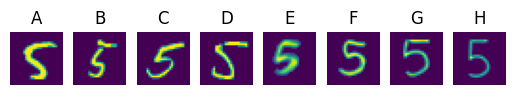

Probabilities for orientation:
(A)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(B)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 0.97    90: 0.01    180: 0.00    270: 0.02    Prediction: 0
(E)    0: 0.00    90: 0.00    180: 1.00    270: 0.00    Prediction: 2
(F)    0: 0.25    90: 0.00    180: 0.75    270: 0.00    Prediction: 2
(G)    0: 0.03    90: 0.02    180: 0.95    270: 0.00    Prediction: 2
(H)    0: 0.18    90: 0.00    180: 0.81    270: 0.00    Prediction: 2


In [12]:
model_ori = load_model(os.path.join('model', 'saved_numori_model'), compile=True)

# np.set_printoptions(linewidth=np.inf, precision=2)

real_5_1 = np.array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.24385833, 0.5440302 , 0.64401887, 0.61737136, 0.5329199 , 0.4183383 , 0.33436283, 0.26897368, 0.1740251 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.25834136, 0.74710471, 0.93554444, 0.94325997, 0.88952162, 0.79254879, 0.71314902, 0.648975  , 0.55329983, 0.38929937, 0.1743973 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.27851398, 0.70731093, 0.94032325, 0.91417223, 0.89051408, 0.89078953, 0.89308689, 0.88732311, 0.87996355, 0.82515133, 0.63504652, 0.31077521, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.19787604, 0.63515472, 0.88358576, 0.64676818, 0.41044326, 0.40465161, 0.44032443, 0.50482217, 0.565104  , 0.63829112, 0.62948633, 0.41479655, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.32385155, 0.74928437, 0.7866013 , 0.31792853, 0.        , 0.        , 0.        , 0.        , 0.14446704, 0.16263571, 0.15176237, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.41813106, 0.8526186 , 0.61247076, 0.15885767, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.16524343, 0.5439305 , 0.86698391, 0.43539932, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.25247509, 0.68125859, 0.71268374, 0.33419467, 0.16577348, 0.25390495, 0.30909099, 0.30021459, 0.24475048, 0.19575333, 0.14083997, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.37970012, 0.75165852, 0.69660226, 0.572508  , 0.65198747, 0.71837987, 0.64435152, 0.52163956, 0.41541607, 0.35786158, 0.34837146, 0.26452103, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.16450356, 0.5181    , 0.86152698, 0.90115746, 0.92423966, 0.95218748, 0.91976799, 0.80854358, 0.70487792, 0.68923178, 0.68194772, 0.62088504, 0.48034547, 0.29651636, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.20703786, 0.57106985, 0.93388122, 1.        , 0.9912422 , 0.85014197, 0.66704727, 0.50298531, 0.47800575, 0.63636384, 0.8442497 , 0.85150263, 0.73633169, 0.47054186, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.17252752, 0.44470698, 0.76078183, 0.83841978, 0.56647623, 0.30092898, 0.1705821 , 0.14398788, 0.18885948, 0.51540787, 0.90558754, 0.93897848, 0.88664598, 0.50933268, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.20848134, 0.30846924, 0.25889794, 0.        , 0.        , 0.        , 0.        , 0.2468899 , 0.72334576, 0.95130566, 0.95127328, 0.8912951 , 0.43063436, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.58455036, 0.90098353, 0.90307002, 0.90569564, 0.69370459, 0.20588444, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.20362431, 0.54370368, 0.83306361, 0.82954117, 0.78511941, 0.65894084, 0.27372311, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.19781746, 0.        , 0.        , 0.28192357, 0.59542381, 0.77982163, 0.79610212, 0.75102454, 0.66433654, 0.27424018, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.18459613, 0.36856638, 0.44371312, 0.54224251, 0.71258387, 0.81247971, 0.78832253, 0.68134515, 0.49183403, 0.23316789, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.15599944, 0.30797774, 0.51597064, 0.66719454, 0.72093849, 0.6785338 , 0.54021456, 0.30217152, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.14181159, 0.22591053, 0.29050669, 0.2906847 , 0.24996816, 0.1526953 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]])

real_5_2 = np.array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.19717915, 0.65417928, 0.58504471, 0.41608174, 0.19344737, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.34545002, 0.81701848, 0.97758322, 0.99099107, 0.97421831, 0.90254583, 0.78359873, 0.6039109 , 0.46767866, 0.35208831, 0.37427763, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.77551306, 0.79741992, 0.30417289, 0.46076298, 0.61164851, 0.75737863, 0.89084772, 0.96291688, 0.97414232, 0.9562176 , 0.78098569, 0.24629193, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.22193241, 0.91590905, 0.49255148, 0.        , 0.        , 0.        , 0.        , 0.16031162, 0.30014303, 0.42137622, 0.46675584, 0.38055521, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.34208172, 0.91923856, 0.28672243, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.34745991, 0.91963451, 0.32752028, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.22854088, 0.9009777 , 0.57577501, 0.        , 0.        , 0.1617317 , 0.23244997, 0.19261429, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.72335893, 0.89764664, 0.62145094, 0.82460336, 0.93746798, 0.95236119, 0.88686809, 0.74207051, 0.41375248, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.35868289, 0.91659737, 1.        , 0.99272416, 0.94099138, 0.8500076 , 0.84169869, 0.94061751, 0.90990993, 0.63347846, 0.1403165 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.51029635, 0.78213426, 0.5361413 , 0.23175533, 0.        , 0.        , 0.35397336, 0.83714082, 0.96080957, 0.63514054, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.39478025, 0.96652278, 0.92520949, 0.21683312, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.27190979, 0.86433021, 0.98262665, 0.2536581 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.2851631 , 0.72706952, 0.94422788, 0.1718833 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.38236041, 0.69696919, 0.8458035 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.22473303, 0.6102385 , 0.86758571, 0.50964221, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.29899318, 0.42311084, 0.18617732, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.28981552, 0.7461158 , 0.90380911, 0.87806285, 0.15617599, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.33433508, 0.79507465, 0.78693994, 0.47022639, 0.23566261, 0.15560069, 0.19697634, 0.34982121, 0.63852089, 0.88985238, 0.94979479, 0.91568544, 0.38574511, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.34169496, 0.77247436, 0.91218113, 0.88132202, 0.84224947, 0.88513144, 0.90999358, 0.91660221, 0.86746851, 0.70011729, 0.29962178, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.1749803 , 0.45832964, 0.71575937, 0.84720543, 0.86135033, 0.78891827, 0.58155184, 0.26883116, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.16181787, 0.15184192, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]])

real_5_3 = np.array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.50302195, 0.4692642 , 0.72283908, 0.99977994, 1.        , 0.98696148, 0.98197071, 0.96238751, 0.91677758, 0.92158291, 0.93642113, 0.98377704, 0.65841506, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.10986007, 0.80586664, 0.45404882, 0.16080474, 0.41344115, 0.5379897 , 0.5713518 , 0.56911095, 0.54486703, 0.49967573, 0.45415406, 0.45105744, 0.52000165, 0.38335135, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.24145687, 0.85717478, 0.26272187, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.38953664, 0.78133231, 0.11435214, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.52375217, 0.63369516, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.64265276, 0.49893497, 0.        , 0.        , 0.15378201, 0.22158114, 0.27767605, 0.2578979 , 0.17384256, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.7090241 , 0.51380226, 0.41360548, 0.69282366, 0.82639467, 0.82717624, 0.80583592, 0.81264987, 0.79688759, 0.70732493, 0.38732111, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.75096388, 0.96308033, 0.9654255 , 0.76359432, 0.47809035, 0.2811222 , 0.22015733, 0.25085703, 0.39278734, 0.6831606 , 0.87925835, 0.52489489, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.64615229, 0.91348502, 0.40659889, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.52421604, 0.87800804, 0.32462245, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.19972416, 0.29492789, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.13948891, 0.7246033 , 0.70327775, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.39799277, 0.81659474, 0.22048359, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.21689822, 0.7696    , 0.38435515, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.17113677, 0.73357699, 0.45415003, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.24972322, 0.82153617, 0.38607277, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.10229737, 0.57114667, 0.82864143, 0.19851181, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.12662835, 0.47525678, 0.79660116, 0.47317922, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.13022427, 0.        , 0.        , 0.        , 0.        , 0.        , 0.31159659, 0.64944061, 0.70421183, 0.41937084, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.30745857, 0.74099737, 0.38606428, 0.14638692, 0.15919427, 0.35590133, 0.64270502, 0.76501596, 0.61357925, 0.24170144, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.47004497, 0.80923463, 0.81241368, 0.74998796, 0.72299715, 0.5575303 , 0.28730924, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.17803993, 0.33427727, 0.31649192, 0.18597805, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]])

real_5_4 = np.array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.08461981, 0.50364798, 0.67607237, 0.66138045, 0.64811056, 0.61977923, 0.61642816, 0.64347562, 0.74055424, 0.75156073, 0.16375741, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.12276127, 0.73278287, 0.38158866, 0.2914037 , 0.27170292, 0.2641898 , 0.27629346, 0.31214624, 0.30789007, 0.19782444, 0.06896866, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.15737896, 0.685957  , 0.11694213, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.18343765, 0.66208766, 0.09118483, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.21771662, 0.64957962, 0.079482  , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.25454585, 0.61334764, 0.06691756, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.27025481, 0.58633915, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.26869545, 0.58140193, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.28757661, 0.66969647, 0.35427706, 0.51320118, 0.56696713, 0.51305584, 0.31034676, 0.11184947, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.37227799, 1.        , 0.73789192, 0.47202249, 0.36723765, 0.46552278, 0.6568909 , 0.71383818, 0.31654392, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.28641109, 0.49845218, 0.09749844, 0.        , 0.        , 0.        , 0.        , 0.26300733, 0.69817864, 0.37964175, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.18355288, 0.69803175, 0.23423097, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.33700589, 0.55756613, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.11638685, 0.67516784, 0.11613629, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.07193241, 0.66071794, 0.17315991, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.1764523 , 0.68239595, 0.10926549, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.10278059, 0.58133321, 0.47610734, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.2163788 , 0.60582283, 0.54332407, 0.0876582 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.25812829, 0.61085063, 0.38394915, 0.24140247, 0.22603058, 0.32043879, 0.57722455, 0.69224175, 0.38979615, 0.07246532, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.2289223 , 0.49761896, 0.63513298, 0.67534149, 0.59030784, 0.36751172, 0.12138342, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]])


model_ori = load_model(os.path.join('model', 'saved_numori_model'), compile=True)
(_, _), (x_test_orig, y_test_orig) = keras.datasets.mnist.load_data()

x_test_orig = x_test_orig.astype("float32") / 255

subimages = []
rot = np.random.randint(1, 4)
rot = 0
while len(subimages) < 4:
    rnd = np.random.randint(0, x_test_orig.shape[0])
    # if y_test_orig[rnd] not in (5, 3):
    #     continue
    if y_test_orig[rnd] != 5:
        continue
    subimage = x_test_orig[rnd]
    subimages.append(np.rot90(subimage, rot))
subimages.append(real_5_1)
subimages.append(real_5_2)
subimages.append(real_5_3)
subimages.append(real_5_4)

subimages = np.array(subimages)

_, ax = plt.subplots(1, subimages.shape[0])
for i in range(subimages.shape[0]):
    ax[i].imshow(subimages[i], vmin=0, vmax=1)
    ax[i].set_title(chr(i%26+65))
    ax[i].axis('off')
plt.show()

predictions_ori = model_ori.predict(np.expand_dims(subimages, -1), verbose=verbose)
print("Probabilities for orientation:")
for j, prediction in enumerate(predictions_ori):
    print(f"({chr(j%26+65)})    ", end="")
    for i, probability in enumerate(prediction):
        print(f"{i*90}: {probability:.02f}    ", end="")
    print(f"Prediction: {np.argmax(prediction)}")    


Note: The first four numbers in the above example are from the training set, the last four numbers are real data.

### Main

In [15]:
# train_and_save_number_orientation_model()
# train_and_save_number_classification_model()



Processing IMG_20190312_185258.jpg


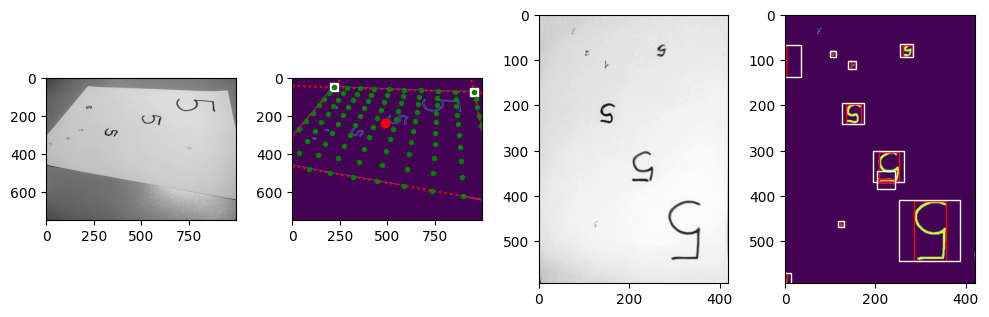

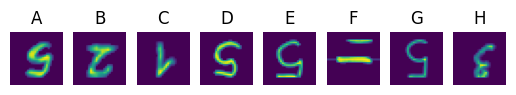

Probabilities for rotation:
(A)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(B)    0: 0.97    90: 0.00    180: 0.02    270: 0.00    Prediction: 0
(C)    0: 0.30    90: 0.00    180: 0.01    270: 0.69    Prediction: 270
(D)    0: 0.37    90: 0.00    180: 0.62    270: 0.01    Prediction: 180
(E)    0: 0.98    90: 0.00    180: 0.00    270: 0.02    Prediction: 0
(F)    0: 0.00    90: 1.00    180: 0.00    270: 0.00    Prediction: 90
(G)    0: 0.97    90: 0.00    180: 0.03    270: 0.00    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.70    90: 0.13    180: 0.08    270: 0.09    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 0.04    4: 0.00    5: 0.90    6: 0.00    7: 0.00    8: 0.00    9: 0.06    Prediction: 5
(B)    0: 0.07    1: 0.01    2: 0.38    3: 0.01    4: 0.00    5: 0.04    6: 0.00    7: 0.01    8: 0.48    9: 0.00    Prediction: 8
(C)    0: 0.09    1: 0.22    2: 0.09    3: 0.0

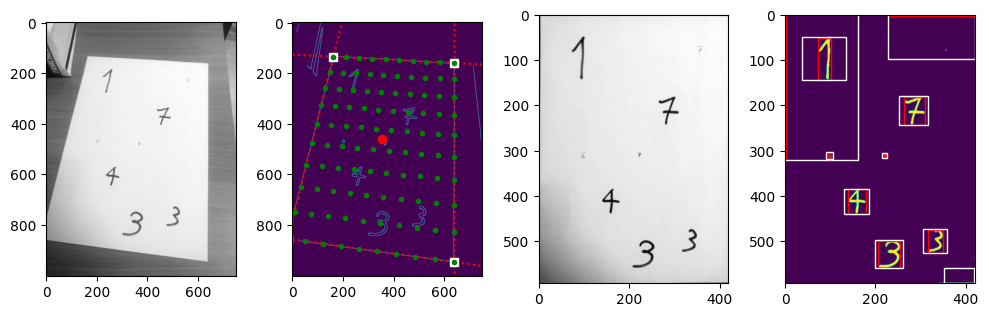

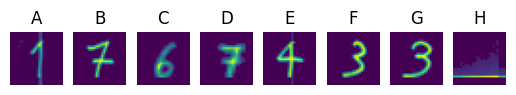

Probabilities for rotation:
(A)    0: 0.89    90: 0.02    180: 0.09    270: 0.00    Prediction: 0
(B)    0: 0.79    90: 0.02    180: 0.18    270: 0.00    Prediction: 0
(C)    0: 0.84    90: 0.00    180: 0.00    270: 0.16    Prediction: 0
(D)    0: 0.92    90: 0.08    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.91    90: 0.00    180: 0.09    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(H)    0: 0.95    90: 0.00    180: 0.00    270: 0.05    Prediction: 0
Mean   0: 0.91    90: 0.02    180: 0.05    270: 0.03    

Probabilities for number classification:
(A)    0: 0.00    1: 0.73    2: 0.03    3: 0.02    4: 0.06    5: 0.00    6: 0.00    7: 0.14    8: 0.00    9: 0.01    Prediction: 1
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 0.00    6: 0.00    7: 1.00    8: 0.00    9: 0.00    Prediction: 7
(C)    0: 0.02    1: 0.01    2: 0.06    3: 0.00    

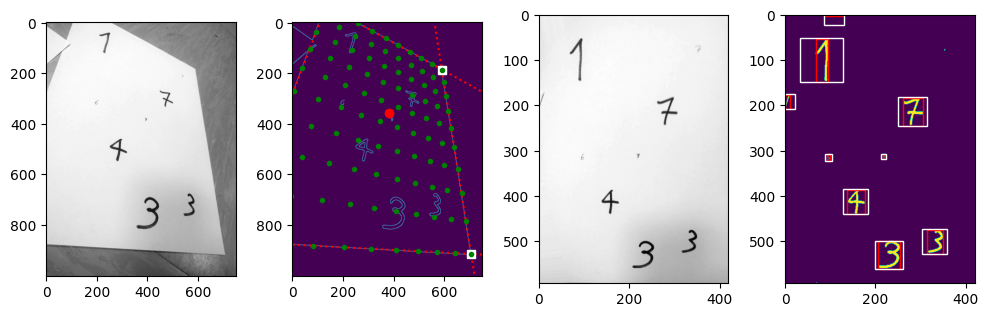

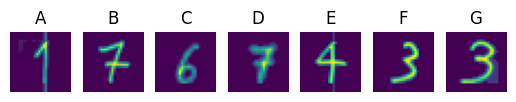

Probabilities for rotation:
(A)    0: 0.75    90: 0.08    180: 0.18    270: 0.00    Prediction: 0
(B)    0: 0.57    90: 0.02    180: 0.41    270: 0.00    Prediction: 0
(C)    0: 0.97    90: 0.00    180: 0.00    270: 0.03    Prediction: 0
(D)    0: 0.97    90: 0.03    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.95    90: 0.00    180: 0.05    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.89    90: 0.02    180: 0.09    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.60    2: 0.05    3: 0.02    4: 0.13    5: 0.00    6: 0.00    7: 0.18    8: 0.00    9: 0.01    Prediction: 1
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 0.00    6: 0.00    7: 0.99    8: 0.00    9: 0.00    Prediction: 7
(C)    0: 0.02    1: 0.01    2: 0.04    3: 0.00    4: 0.00    5: 0.04    6: 0.77    7: 0.00    8: 0.12    9: 0.00    Pred

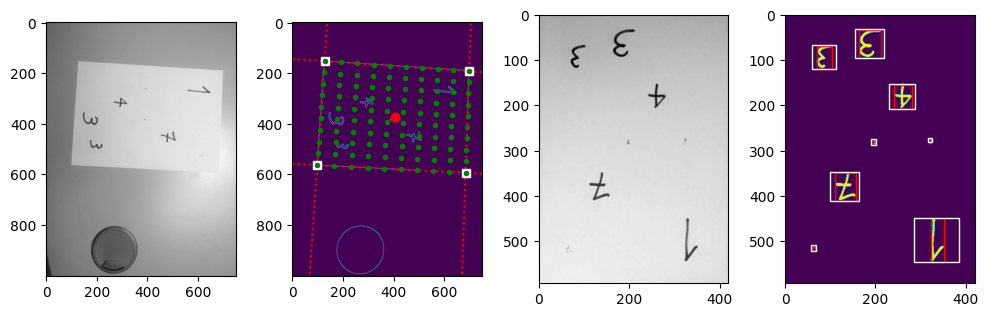

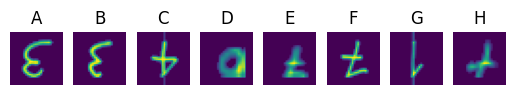

Probabilities for rotation:
(A)    0: 0.00    90: 0.00    180: 0.99    270: 0.01    Prediction: 180
(B)    0: 0.00    90: 0.00    180: 1.00    270: 0.00    Prediction: 180
(C)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 0.31    90: 0.00    180: 0.45    270: 0.24    Prediction: 180
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.66    90: 0.00    180: 0.31    270: 0.03    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 0.51    6: 0.02    7: 0.00    8: 0.48    9: 0.00    Prediction: 5
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 0.26    6: 0.00    7: 0.00    8: 0.74    9: 0.00    Prediction: 8
(C)    0: 0.00    1: 0.00    2: 0.00    3: 0.

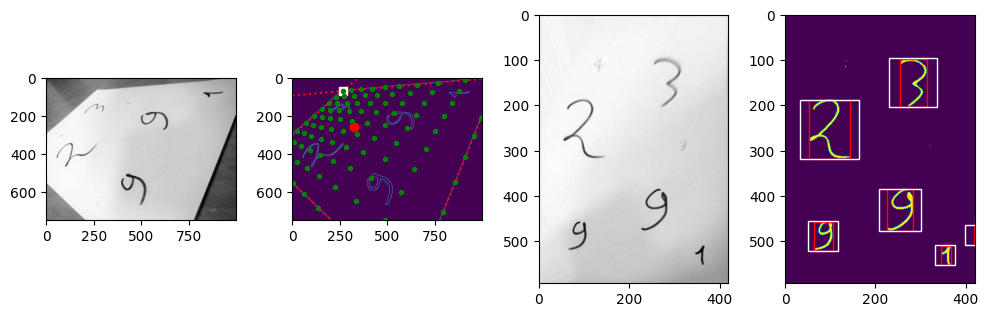

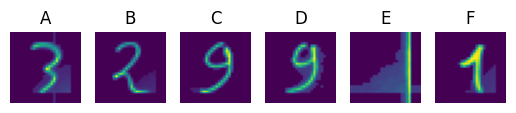

Probabilities for rotation:
(A)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(B)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 1.00    90: 0.00    180: 0.00    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 1.00    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 3
(B)    0: 0.00    1: 0.02    2: 0.97    3: 0.01    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 2
(C)    0: 0.00    1: 0.00    2: 0.01    3: 0.22    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.76    Prediction: 9
(D)    0: 0.00    1: 0.00    2: 0.00    3: 0.05    4: 0.02  

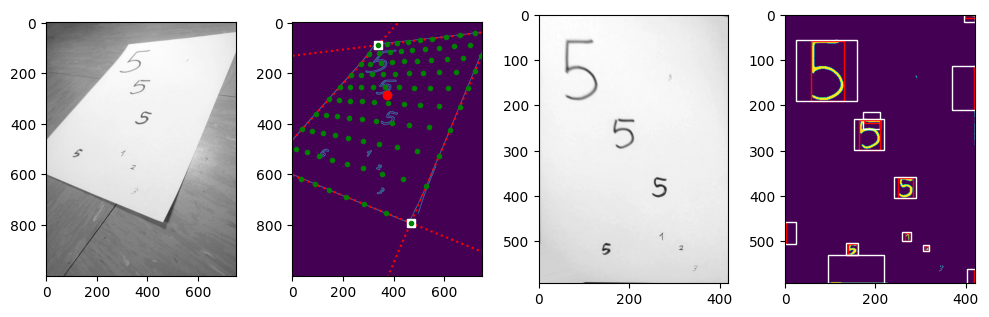

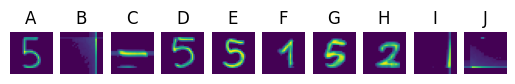

Probabilities for rotation:
(A)    0: 0.88    90: 0.00    180: 0.10    270: 0.02    Prediction: 0
(B)    0: 0.00    90: 1.00    180: 0.00    270: 0.00    Prediction: 90
(C)    0: 0.01    90: 0.00    180: 0.00    270: 0.99    Prediction: 270
(D)    0: 0.78    90: 0.17    180: 0.05    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(I)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
(J)    0: 0.00    90: 0.00    180: 0.00    270: 1.00    Prediction: 270
Mean   0: 0.67    90: 0.12    180: 0.02    270: 0.20    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 1.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 5
(B)    0: 0.07    1: 0.07    2: 0.01 

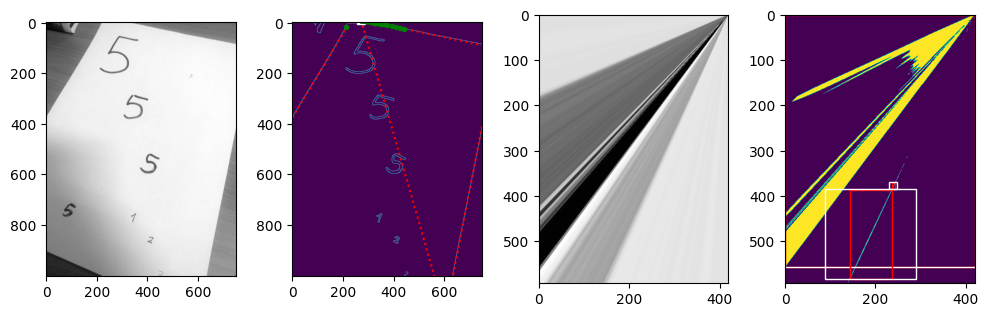

Sheet not detectable, skipping


Processing IMG_20190312_184053.jpg


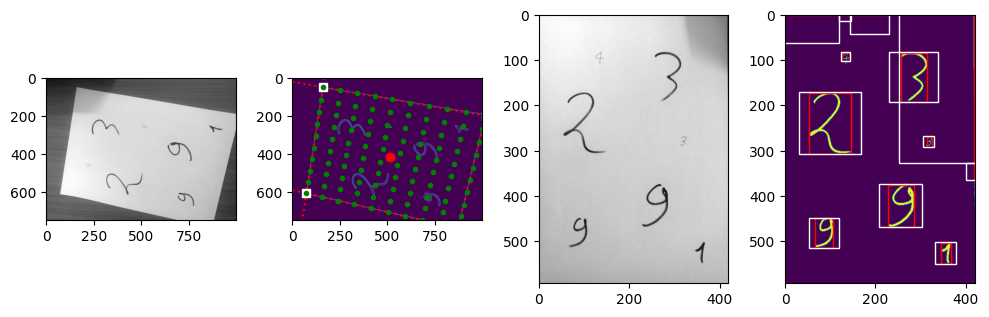

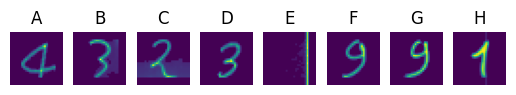

Probabilities for rotation:
(A)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(B)    0: 0.86    90: 0.14    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 0.87    90: 0.00    180: 0.00    270: 0.13    Prediction: 0
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.17    90: 0.83    180: 0.00    270: 0.00    Prediction: 90
(F)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.86    90: 0.12    180: 0.00    270: 0.02    

Probabilities for number classification:
(A)    0: 0.17    1: 0.14    2: 0.14    3: 0.01    4: 0.44    5: 0.01    6: 0.03    7: 0.03    8: 0.02    9: 0.02    Prediction: 4
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.99    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 3
(C)    0: 0.00    1: 0.01    2: 0.98    3: 0.01   

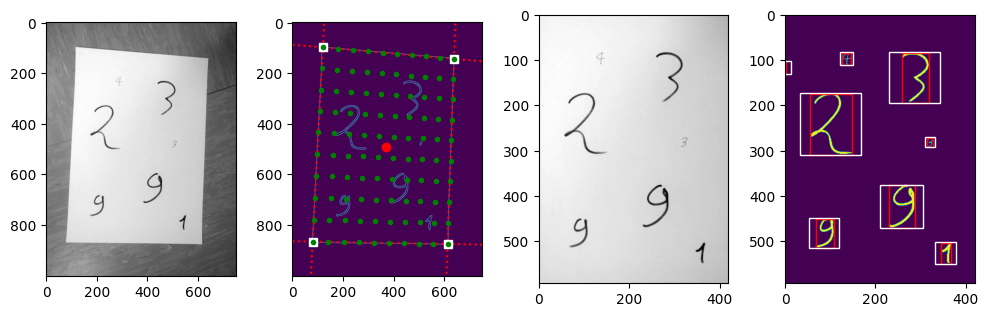

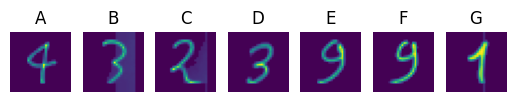

Probabilities for rotation:
(A)    0: 0.95    90: 0.01    180: 0.04    270: 0.00    Prediction: 0
(B)    0: 0.60    90: 0.40    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.98    90: 0.02    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.93    90: 0.06    180: 0.01    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.01    3: 0.01    4: 0.73    5: 0.00    6: 0.00    7: 0.05    8: 0.13    9: 0.07    Prediction: 4
(B)    0: 0.00    1: 0.00    2: 0.01    3: 0.99    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 3
(C)    0: 0.00    1: 0.01    2: 0.98    3: 0.00    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Pred

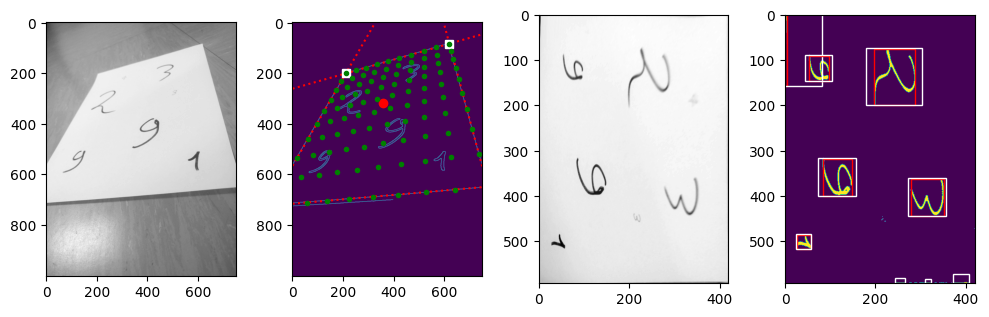

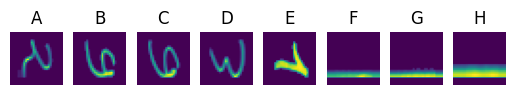

Probabilities for rotation:
(A)    0: 0.01    90: 0.16    180: 0.17    270: 0.67    Prediction: 270
(B)    0: 0.06    90: 0.00    180: 0.00    270: 0.94    Prediction: 270
(C)    0: 0.66    90: 0.00    180: 0.00    270: 0.34    Prediction: 0
(D)    0: 0.82    90: 0.00    180: 0.00    270: 0.18    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 0.65    90: 0.00    180: 0.00    270: 0.35    Prediction: 0
(G)    0: 0.48    90: 0.00    180: 0.00    270: 0.52    Prediction: 270
(H)    0: 0.01    90: 0.00    180: 0.00    270: 0.99    Prediction: 270
Mean   0: 0.46    90: 0.02    180: 0.02    270: 0.50    

Probabilities for number classification:
(A)    0: 0.04    1: 0.04    2: 0.67    3: 0.00    4: 0.24    5: 0.00    6: 0.00    7: 0.01    8: 0.00    9: 0.00    Prediction: 2
(B)    0: 0.09    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 0.00    6: 0.91    7: 0.00    8: 0.00    9: 0.00    Prediction: 6
(C)    0: 0.47    1: 0.00    2: 0.00    3: 

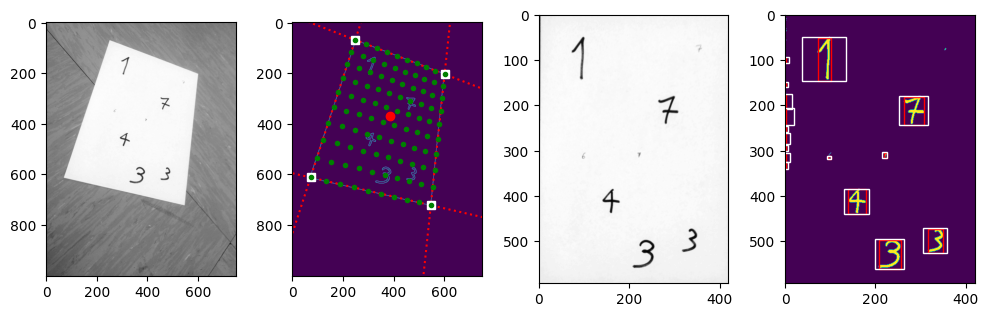

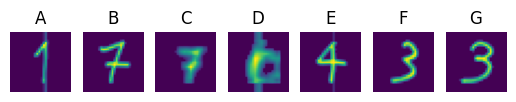

Probabilities for rotation:
(A)    0: 0.92    90: 0.02    180: 0.06    270: 0.00    Prediction: 0
(B)    0: 0.62    90: 0.07    180: 0.31    270: 0.00    Prediction: 0
(C)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.95    90: 0.00    180: 0.04    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.93    90: 0.01    180: 0.06    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.76    2: 0.03    3: 0.01    4: 0.08    5: 0.01    6: 0.00    7: 0.10    8: 0.00    9: 0.01    Prediction: 1
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 0.00    6: 0.00    7: 1.00    8: 0.00    9: 0.00    Prediction: 7
(C)    0: 0.00    1: 0.00    2: 0.01    3: 0.14    4: 0.00    5: 0.02    6: 0.00    7: 0.77    8: 0.01    9: 0.04    Pred

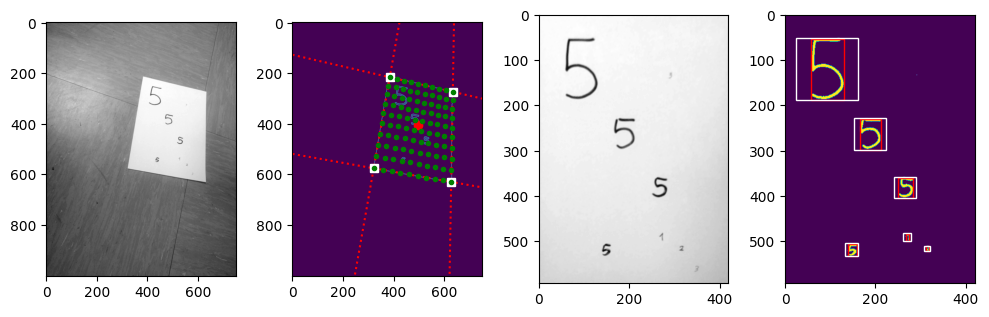

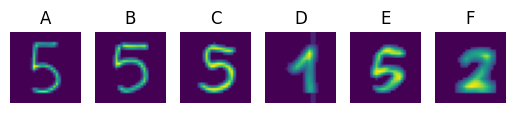

Probabilities for rotation:
(A)    0: 0.91    90: 0.00    180: 0.08    270: 0.01    Prediction: 0
(B)    0: 0.30    90: 0.10    180: 0.61    270: 0.00    Prediction: 180
(C)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.87    90: 0.02    180: 0.11    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 1.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 5
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 1.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 5
(C)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 1.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 5
(D)    0: 0.00    1: 0.47    2: 0.01    3: 0.03    4: 0.24

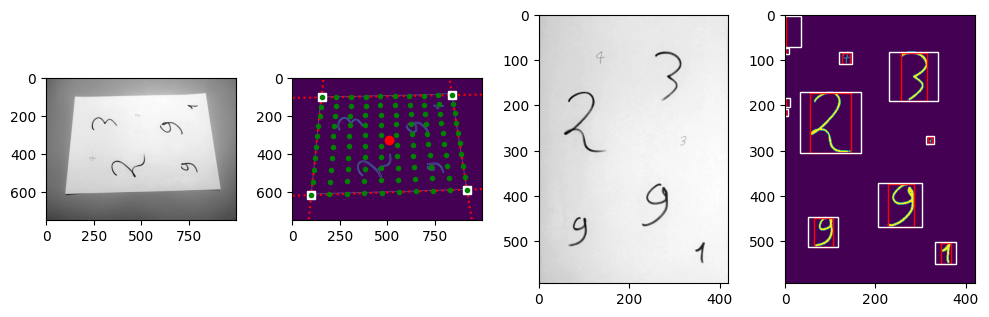

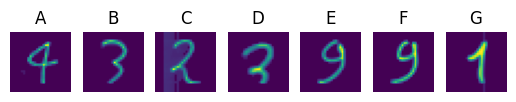

Probabilities for rotation:
(A)    0: 0.90    90: 0.04    180: 0.06    270: 0.00    Prediction: 0
(B)    0: 0.70    90: 0.27    180: 0.03    270: 0.00    Prediction: 0
(C)    0: 0.00    90: 0.00    180: 1.00    270: 0.00    Prediction: 180
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.98    90: 0.02    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.80    90: 0.05    180: 0.16    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.84    5: 0.00    6: 0.00    7: 0.02    8: 0.08    9: 0.06    Prediction: 4
(B)    0: 0.00    1: 0.00    2: 0.00    3: 1.00    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 3
(C)    0: 0.00    1: 0.01    2: 0.97    3: 0.01    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Pr

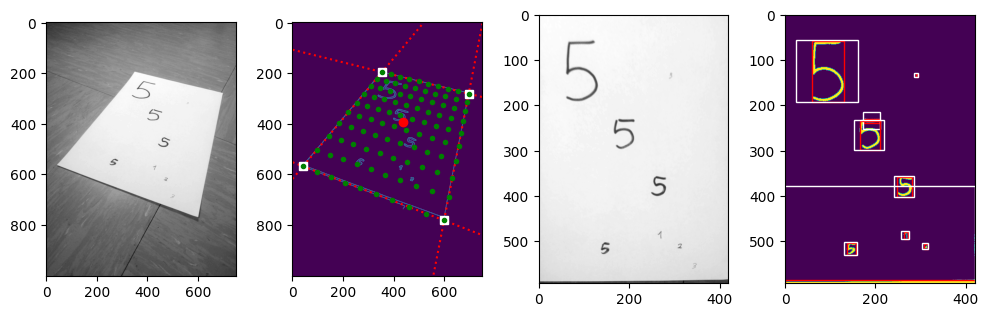

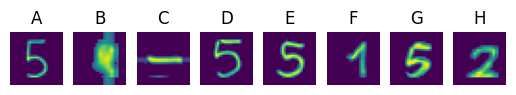

Probabilities for rotation:
(A)    0: 0.95    90: 0.00    180: 0.04    270: 0.01    Prediction: 0
(B)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 0.03    90: 0.03    180: 0.00    270: 0.94    Prediction: 270
(D)    0: 0.78    90: 0.15    180: 0.07    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.84    90: 0.02    180: 0.01    270: 0.12    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 1.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 5
(B)    0: 0.00    1: 0.80    2: 0.01    3: 0.03    4: 0.06    5: 0.01    6: 0.00    7: 0.01    8: 0.01    9: 0.06    Prediction: 1
(C)    0: 0.00    1: 0.00    2: 0.62    3: 0.02  

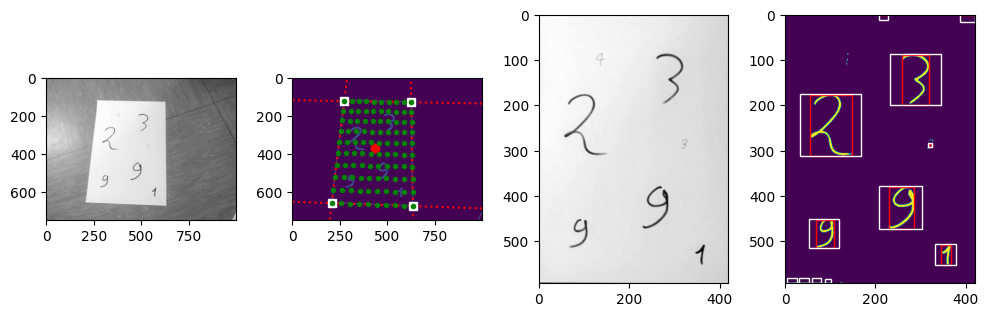

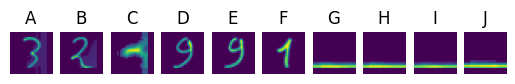

Probabilities for rotation:
(A)    0: 0.86    90: 0.14    180: 0.00    270: 0.00    Prediction: 0
(B)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 0.00    90: 1.00    180: 0.00    270: 0.00    Prediction: 90
(D)    0: 0.98    90: 0.02    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 0.04    90: 0.00    180: 0.00    270: 0.96    Prediction: 270
(H)    0: 0.03    90: 0.00    180: 0.00    270: 0.97    Prediction: 270
(I)    0: 0.14    90: 0.00    180: 0.00    270: 0.86    Prediction: 270
(J)    0: 0.06    90: 0.00    180: 0.00    270: 0.94    Prediction: 270
Mean   0: 0.51    90: 0.12    180: 0.00    270: 0.37    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.01    3: 0.99    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 3
(B)    0: 0.00    1: 0.01    2: 0

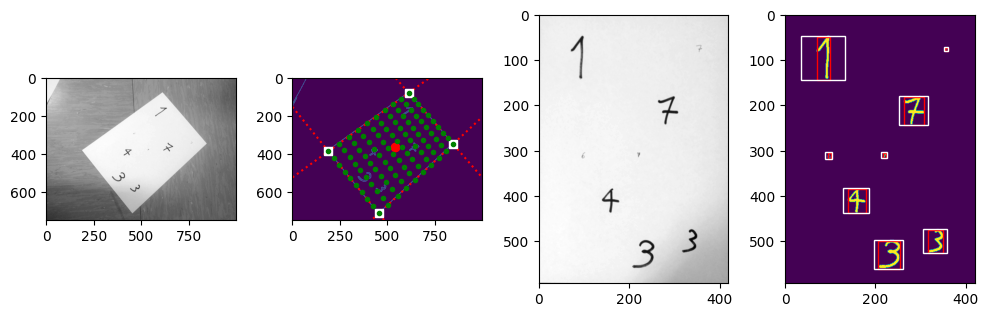

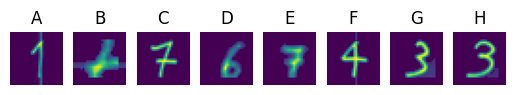

Probabilities for rotation:
(A)    0: 0.92    90: 0.02    180: 0.06    270: 0.00    Prediction: 0
(B)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 0.70    90: 0.01    180: 0.29    270: 0.00    Prediction: 0
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 0.93    90: 0.01    180: 0.07    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.94    90: 0.00    180: 0.05    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.72    2: 0.04    3: 0.02    4: 0.08    5: 0.00    6: 0.00    7: 0.13    8: 0.00    9: 0.01    Prediction: 1
(B)    0: 0.02    1: 0.08    2: 0.73    3: 0.01    4: 0.04    5: 0.00    6: 0.12    7: 0.01    8: 0.00    9: 0.00    Prediction: 2
(C)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    

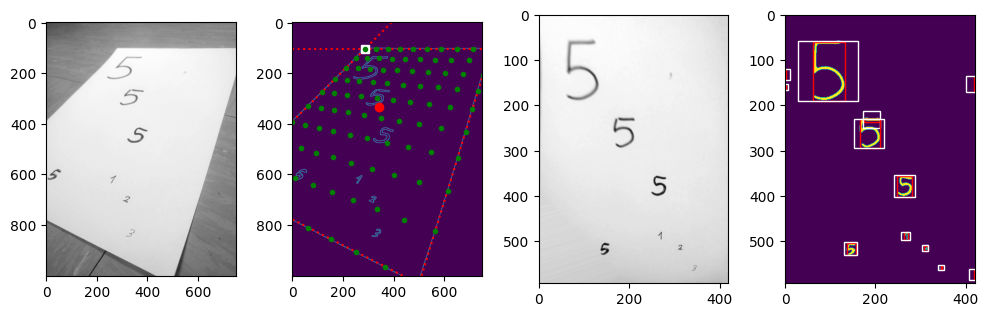

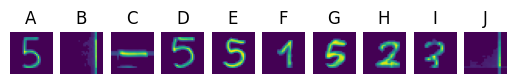

Probabilities for rotation:
(A)    0: 0.93    90: 0.00    180: 0.04    270: 0.02    Prediction: 0
(B)    0: 0.51    90: 0.49    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 0.01    90: 0.01    180: 0.00    270: 0.98    Prediction: 270
(D)    0: 0.81    90: 0.12    180: 0.06    270: 0.00    Prediction: 0
(E)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(I)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(J)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.83    90: 0.06    180: 0.01    270: 0.10    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 1.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 5
(B)    0: 0.01    1: 0.02    2: 0.00    

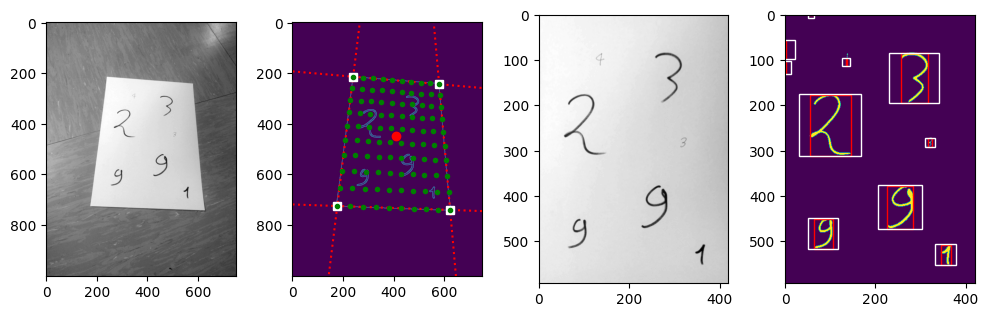

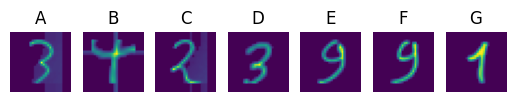

Probabilities for rotation:
(A)    0: 0.96    90: 0.04    180: 0.00    270: 0.00    Prediction: 0
(B)    0: 0.00    90: 0.89    180: 0.11    270: 0.00    Prediction: 90
(C)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.99    90: 0.01    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.85    90: 0.14    180: 0.02    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.00    2: 0.01    3: 0.99    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Prediction: 3
(B)    0: 0.00    1: 0.38    2: 0.00    3: 0.00    4: 0.01    5: 0.03    6: 0.00    7: 0.47    8: 0.11    9: 0.00    Prediction: 7
(C)    0: 0.00    1: 0.02    2: 0.98    3: 0.01    4: 0.00    5: 0.00    6: 0.00    7: 0.00    8: 0.00    9: 0.00    Pre

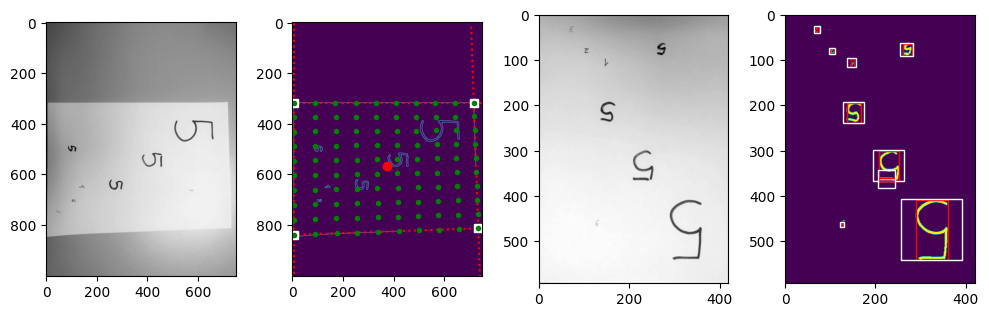

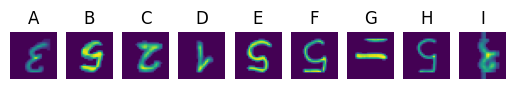

Probabilities for rotation:
(A)    0: 0.99    90: 0.00    180: 0.01    270: 0.00    Prediction: 0
(B)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(C)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(D)    0: 0.94    90: 0.00    180: 0.00    270: 0.06    Prediction: 0
(E)    0: 0.56    90: 0.00    180: 0.43    270: 0.01    Prediction: 0
(F)    0: 0.99    90: 0.00    180: 0.00    270: 0.01    Prediction: 0
(G)    0: 0.00    90: 1.00    180: 0.00    270: 0.00    Prediction: 90
(H)    0: 0.91    90: 0.01    180: 0.08    270: 0.00    Prediction: 0
(I)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.82    90: 0.11    180: 0.06    270: 0.01    

Probabilities for number classification:
(A)    0: 0.01    1: 0.00    2: 0.05    3: 0.02    4: 0.00    5: 0.16    6: 0.06    7: 0.00    8: 0.65    9: 0.04    Prediction: 8
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.02    4: 0.00    5: 0.96    6: 0.00    7: 0.00    8: 0.00    9: 0.

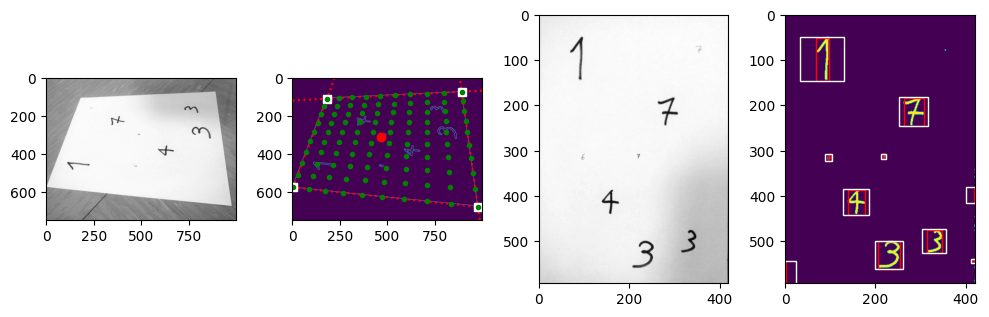

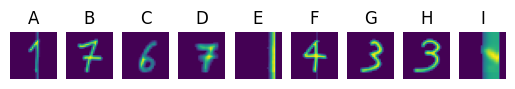

Probabilities for rotation:
(A)    0: 0.91    90: 0.03    180: 0.07    270: 0.00    Prediction: 0
(B)    0: 0.61    90: 0.02    180: 0.37    270: 0.00    Prediction: 0
(C)    0: 0.99    90: 0.00    180: 0.00    270: 0.01    Prediction: 0
(D)    0: 0.98    90: 0.02    180: 0.00    270: 0.00    Prediction: 0
(E)    0: 0.51    90: 0.49    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 0.89    90: 0.00    180: 0.11    270: 0.00    Prediction: 0
(G)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(I)    0: 0.70    90: 0.30    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.84    90: 0.09    180: 0.06    270: 0.00    

Probabilities for number classification:
(A)    0: 0.00    1: 0.73    2: 0.04    3: 0.02    4: 0.08    5: 0.00    6: 0.00    7: 0.12    8: 0.00    9: 0.01    Prediction: 1
(B)    0: 0.00    1: 0.00    2: 0.00    3: 0.00    4: 0.00    5: 0.00    6: 0.00    7: 0.99    8: 0.00    9: 0.0

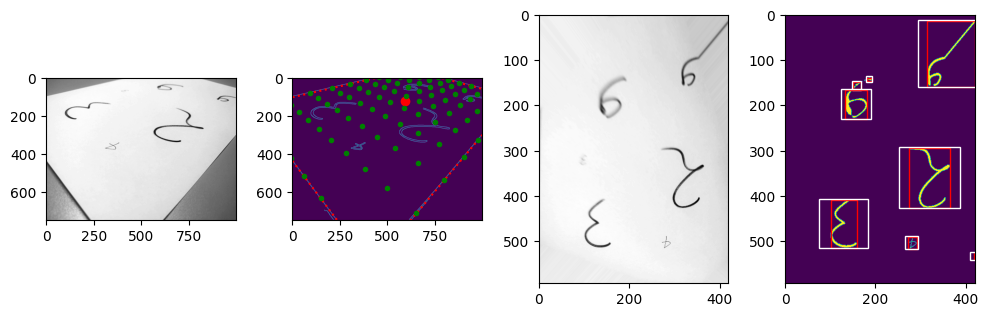

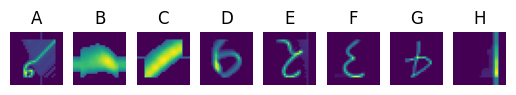

Probabilities for rotation:
(A)    0: 0.67    90: 0.33    180: 0.00    270: 0.00    Prediction: 0
(B)    0: 0.00    90: 0.00    180: 0.00    270: 1.00    Prediction: 270
(C)    0: 0.01    90: 0.77    180: 0.01    270: 0.22    Prediction: 90
(D)    0: 0.00    90: 0.00    180: 0.32    270: 0.68    Prediction: 270
(E)    0: 0.99    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
(F)    0: 0.30    90: 0.00    180: 0.19    270: 0.51    Prediction: 270
(G)    0: 0.99    90: 0.00    180: 0.00    270: 0.01    Prediction: 0
(H)    0: 1.00    90: 0.00    180: 0.00    270: 0.00    Prediction: 0
Mean   0: 0.50    90: 0.14    180: 0.07    270: 0.30    

Probabilities for number classification:
(A)    0: 0.01    1: 0.02    2: 0.14    3: 0.00    4: 0.01    5: 0.00    6: 0.01    7: 0.00    8: 0.81    9: 0.00    Prediction: 8
(B)    0: 0.20    1: 0.00    2: 0.73    3: 0.01    4: 0.02    5: 0.00    6: 0.01    7: 0.00    8: 0.00    9: 0.01    Prediction: 2
(C)    0: 0.80    1: 0.01    2: 0.04    3: 0

In [16]:
model_num = load_model(os.path.join('model', 'saved_numclass_model'), compile=True)
model_ori = load_model(os.path.join('model', 'saved_numori_model'), compile=True)

for imdata in get_scaled_images(imgdir):
    fig, ax = plt.subplots(1, 4, figsize=(10, 10))
    ax[0].imshow(imdata, cmap="gray")

    lines, imedges = find_sheet_lines(imdata)

    for line in lines:
        denom = np.sin(line[1])
        if denom == 0:
            denom = 0.0001
        x0 = 0
        x1 = len(imdata[0])
        y0 = (line[0]-x0*np.cos(line[1])) / denom
        y1 = (line[0]-x1*np.cos(line[1])) / denom
        ax[1].plot([x0,x1], [y0,y1], 'r:', scalex=False, scaley=False) 

    intersections = find_intersections(lines, imdata)
    intersections = sort_intersections(intersections)

    for intersection in intersections:
        ax[1].plot(intersection[0], intersection[1], 'ws', scalex=False, scaley=False)     
    if verbose:
        print(intersections)

    if is_portrait(intersections):
        w, h = a4w, a4h
    else:
        h, w = a4w, a4h

    invtf, imdata_tf = get_transformed_subimage(imdata, intersections, w, h)  

    center_point = invtf((w/2,h/2))
    ax[1].plot(center_point[0,0], center_point[0,1], 'ro', scalex=False, scaley=False) 

    for x in np.arange(0,w+w/10,w/9):
        for y in np.arange(0,h+h/10,h/9):
            p = invtf((x,y))
            ax[1].plot(p[0,0],p[0,1],'g.')

    ax[1].imshow(imedges)

    if w > h:
        imdata_tf = np.rot90(imdata_tf, 3)

    ax[2].imshow(imdata_tf, cmap="gray")

    background = skimage.filters.gaussian(imdata_tf, sigma=bbs, mode='nearest')
    im_min = imdata_tf - background
    mask = im_min < -0.1
    ax[3].imshow(mask)

    fig.tight_layout()

    labels = skimage.measure.label(mask)
    regions = skimage.measure.regionprops(labels)
    regions = [r for r in regions if r.area > rms]

    subimages = []
    for r in regions:
        (min_row, min_col, max_row, max_col) = r.bbox
        width = max_col - min_col
        height = max_row - min_row
        rect = patches.Rectangle((min_col,min_row), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax[3].add_patch(rect)
        size = max(width, height)
        centerx, centery = min_col+width/2, min_row+height/2
        size+=2 # extend bounding boxes by one pixel on each side
        ulx, uly = int(centerx-size/2-1), int(centery-size/2-1)
        rect = patches.Rectangle((ulx,uly), size, size, linewidth=1, edgecolor='w', facecolor='none')
        ax[3].add_patch(rect)
        subimage = imdata_tf[uly:uly+size,ulx:ulx+size]
        if min(subimage.shape) > 5:
            # subimages.append(skimage.transform.resize(1-subimage, [dis, dis]))
            # replicate the same padding as in the MNIST training set
            padded = np.pad(skimage.transform.resize(skimage.util.invert(subimage), [dis-8, dis-8]), (4, 4), 'minimum')
            subimages.append(padded)

    plt.show()

    if len(subimages) < 4:
        print("Sheet not detectable, skipping")
        continue

    # standardization
    # mean_px = subimages.mean().astype(np.float32)
    # std_px = subimages.std().astype(np.float32)
    # subimages = (subimages - mean_px)/(std_px)

    # swap with 10 random numbers from the test set randomly rotated
    # subimages = []
    # (_, _), (x_test_orig, _) = keras.datasets.mnist.load_data()
    # rot = np.random.randint(1, 4)
    # for i in range(10):
    #     subimage = x_test_orig[np.random.randint(0, x_test_orig.shape[1])]
    #     subimages.append(np.rot90(subimage, rot))

    subimages = np.array(subimages)

    _, ax = plt.subplots(1, len(subimages))
    for i, subimage in enumerate(subimages):

        # subimage = ndimage.grey_dilation(subimage, size=(2,2))

        subimage = (subimage-np.min(subimage))/(np.max(subimage)-np.min(subimage))
        subimage[subimage < np.mean(subimage)] = 0
        subimages[i] = subimage
        # print(np.max(subimage))
        # print(np.min(subimage))
        # print(repr(subimage))

        ax[i].imshow(subimage)
        ax[i].set_title(chr(i%26+65))
        ax[i].axis('off')

    plt.show()

    # unfortunately the rotation classifier is not usable
    predictions_ori = model_ori.predict(np.expand_dims(subimages, -1), verbose=verbose)
    print(f"Probabilities for rotation:")
    for j, prediction in enumerate(predictions_ori):
        print(f"({chr(j%26+65)})    ", end="")
        for i, probability in enumerate(prediction):
            print(f"{i*90}: {probability:.02f}    ", end="")
        print(f"Prediction: {np.argmax(prediction)*90}")   
    print(f"Mean   ", end="")
    for i in range(4):
        print(f"{i*90}: {np.mean(predictions_ori[:,i]):.2f}    ", end="")

    print()
    print()

    predictions_num = model_num.predict(np.expand_dims(subimages, -1), verbose=verbose)
    print("Probabilities for number classification:")
    for j, prediction in enumerate(predictions_num):
        print(f"({chr(j%26+65)})    ", end="")
        for i, probability in enumerate(prediction):
            print(f"{i}: {probability:.02f}    ", end="")
        print(f"Prediction: {np.argmax(prediction)}")